In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    Input,
    BatchNormalization,
)
from tensorflow.keras.preprocessing.image import (
    load_img,
    img_to_array,
)
from tensorflow.data import AUTOTUNE

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.10.1


In [2]:
# Check for GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
  print("GPU is available and TensorFlow should use it.")
else:
  print("GPU not found. TensorFlow will use the CPU.")

1 Physical GPUs, 1 Logical GPUs
GPU is available and TensorFlow should use it.


In [3]:
# --- Paths ---
BASE_FOLDER = "."
PROCESSED_FOLDER = os.path.join(BASE_FOLDER, "processed_datasets")
IMAGE_FOLDER = os.path.join(BASE_FOLDER, "original_datasets", "images_gz2", "images")
LABEL_FILE = os.path.join(PROCESSED_FOLDER, "gz2_simplified_labels.csv")

# --- Parameters ---
NUM_IMAGES_TO_USE = 239692
IMG_HEIGHT = 128 # Resize images to this height
IMG_WIDTH = 128 # Resize images to this width
BATCH_SIZE = 32
EPOCHS = 15
VALIDATION_SPLIT = 0.2 # Use 20% of the data for validation

# --- Class Handling ---
# From the previous output: Featured, Uncertain, Smooth, Artifact
# Artifact has very few samples (3), let's exclude it for stable training
CLASSES_TO_EXCLUDE = ["Artifact"]

In [4]:
# --- Additional Configuration (Add near top of cell or in Cell 2) ---
MAPPING_FILE = os.path.join(
    BASE_FOLDER, "original_datasets", "gz2_filename_mapping.csv"
)

# --- Load the simplified labels ---
try:
    labels_df = pd.read_csv(LABEL_FILE)
    print(f"Loaded labels for {len(labels_df)} galaxies.")
except FileNotFoundError:
    print(f"ERROR: Label file not found at {LABEL_FILE}")
    raise

# --- Load the filename mapping ---
try:
    mapping_df = pd.read_csv(MAPPING_FILE)
    # Rename columns for clarity and easier merging
    mapping_df = mapping_df.rename(
        columns={"objid": "dr7objid", "asset_id": "image_filename_base"}
    )
    print(f"Loaded mapping for {len(mapping_df)} files.")
except FileNotFoundError:
    print(f"ERROR: Mapping file not found at {MAPPING_FILE}")
    raise
except Exception as e:
    print(f"Error loading mapping file: {e}")
    raise

# --- Prepare for Merge: Ensure IDs are compatible types ---
# dr7objid in labels_df is likely int64 or string
# dr7objid in mapping_df (originally objid) might be float due to scientific notation
# Convert both to string for robust merging
labels_df["dr7objid"] = labels_df["dr7objid"].astype(str)

# Handle potential scientific notation in mapping file's ID
# Convert to float -> int64 (handles large numbers) -> string
try:
    mapping_df["dr7objid"] = (
        mapping_df["dr7objid"].astype(str)
    )
    print("Successfully converted mapping IDs for merging.")
except ValueError as e:
    print(f"ERROR: Could not convert mapping 'objid' column: {e}")
    print("Check the format of the 'objid' column in the mapping file.")
    raise

# --- Merge labels with mapping ---
print("Merging labels with filename mapping...")
# Use 'inner' merge to keep only galaxies present in both files
merged_df = pd.merge(
    labels_df,
    mapping_df[["dr7objid", "image_filename_base"]], # Select only needed columns
    on="dr7objid",
    how="inner",
)
print(f"Merged DataFrame size: {len(merged_df)}")
if len(merged_df) == 0:
    print(
        "ERROR: Merge resulted in an empty DataFrame. Check ID matching."
    )
    raise ValueError("Merge failed, no matching IDs found.")


# --- Filter out excluded classes ---
print(f"\nFiltering out classes: {CLASSES_TO_EXCLUDE}")
# Use the merged dataframe from now on
merged_df = merged_df[
    ~merged_df["simplified_class"].isin(CLASSES_TO_EXCLUDE)
]
print(f"\nLabels remaining after filtering: {len(merged_df)}")
print("Label distribution after filtering:")
print(merged_df["simplified_class"].value_counts())

# --- Select a subset of images ---
if NUM_IMAGES_TO_USE < len(merged_df):
    print(f"\nSelecting a subset of {NUM_IMAGES_TO_USE} images...")
    # Sample randomly from the merged dataframe
    final_df = merged_df.sample(n=NUM_IMAGES_TO_USE, random_state=42)
else:
    print("\nUsing all available images after filtering.")
    final_df = merged_df
    NUM_IMAGES_TO_USE = len(final_df) # Update count if using all

print(f"\nFinal number of images selected for training/validation: {len(final_df)}")
print("Final label distribution for the subset:")
print(final_df["simplified_class"].value_counts())

# --- Add the full image path using the mapped filename base ---
# The image files are named like '1.jpg', '2.jpg', etc.
def get_image_path(image_filename_base):
    # Ensure the base is treated as an integer before formatting
    return os.path.join(IMAGE_FOLDER, f"{int(image_filename_base)}.jpg")

final_df["image_path"] = final_df["image_filename_base"].apply(get_image_path)

# --- Verify image files exist ---
print("\nChecking if image files exist...")
final_df["file_exists"] = final_df["image_path"].apply(os.path.exists)
missing_files = final_df[~final_df["file_exists"]]

if not missing_files.empty:
    print(f"WARNING: {len(missing_files)} image files are missing!")
    print("Example missing files:")
    print(missing_files["image_path"].head())
    # Remove rows with missing files
    final_df = final_df[final_df["file_exists"]]
    print(f"Removed missing files. {len(final_df)} samples remaining.")
    if len(final_df) == 0:
        print("ERROR: No images found after checking file existence.")
        raise FileNotFoundError("No valid image paths found.")
else:
    print("All image files for the selected subset seem to exist.")

# --- Prepare for ML: Encode labels and split data ---
# Use the final dataframe which has passed all checks
image_paths = final_df["image_path"].values
class_names = final_df["simplified_class"].values

# Encode string labels to integers (0, 1, 2...)
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(class_names)
NUM_CLASSES = len(label_encoder.classes_)
print(f"\nEncoded labels. Number of classes: {NUM_CLASSES}")
print("Class mapping:", dict(zip(label_encoder.classes_, range(NUM_CLASSES))))

# One-hot encode the integer labels (e.g., 2 -> [0, 0, 1])
one_hot_labels = to_categorical(integer_labels, num_classes=NUM_CLASSES) # This should work now

# Split into training and validation sets
print(f"\nSplitting data into training and validation sets ({1-VALIDATION_SPLIT:.0%} train / {VALIDATION_SPLIT:.0%} val)...")
X_train_paths, X_val_paths, y_train, y_val = train_test_split(
    image_paths,
    one_hot_labels,
    test_size=VALIDATION_SPLIT,
    random_state=42,
    stratify=one_hot_labels, # Try to keep class proportions same in both sets
)

print(f"Training samples: {len(X_train_paths)}")
print(f"Validation samples: {len(X_val_paths)}")

Loaded labels for 239695 galaxies.
Loaded mapping for 355990 files.
Successfully converted mapping IDs for merging.
Merging labels with filename mapping...
Merged DataFrame size: 239695

Filtering out classes: ['Artifact']

Labels remaining after filtering: 239692
Label distribution after filtering:
simplified_class
Featured     102626
Uncertain     83437
Smooth        53629
Name: count, dtype: int64

Using all available images after filtering.

Final number of images selected for training/validation: 239692
Final label distribution for the subset:
simplified_class
Featured     102626
Uncertain     83437
Smooth        53629
Name: count, dtype: int64

Checking if image files exist...
Example missing files:
2753      .\original_datasets\images_gz2\images\26603.jpg
2942     .\original_datasets\images_gz2\images\222471.jpg
12780      .\original_datasets\images_gz2\images\7350.jpg
13639     .\original_datasets\images_gz2\images\59271.jpg
14388     .\original_datasets\images_gz2\images\33878


TensorFlow datasets created.
Training dataset spec: (TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))
Validation dataset spec: (TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))


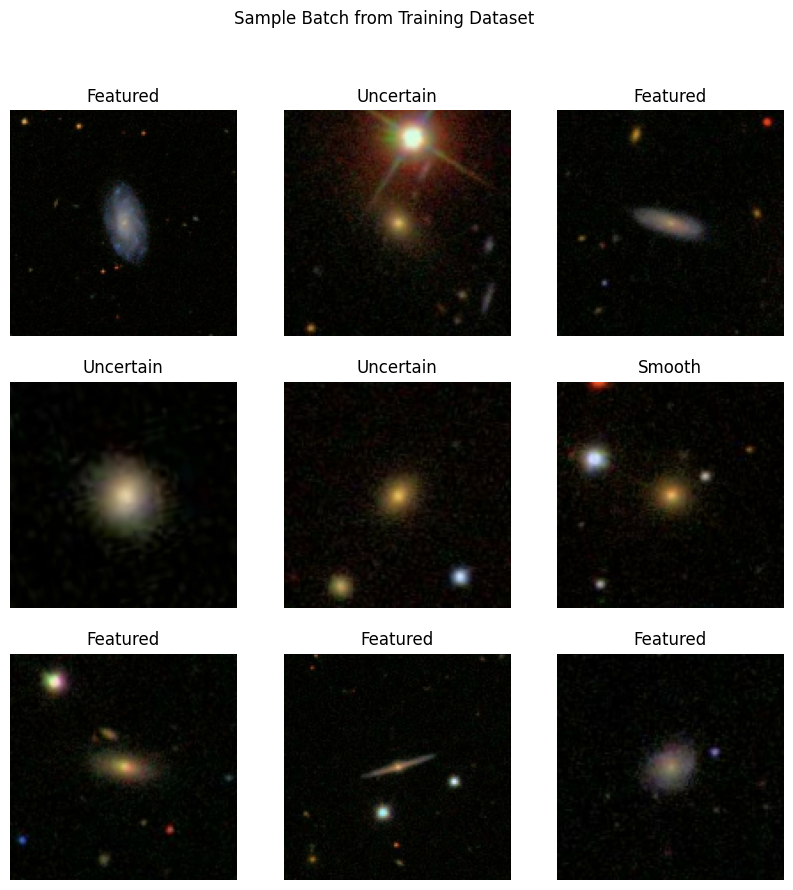

In [5]:
def load_and_preprocess_image(path, label):
    """Loads, decodes, resizes, and normalizes an image."""
    try:
        # Read the file from disk
        image = tf.io.read_file(path)
        # Decode JPEG image (adjust if you have PNGs etc.)
        image = tf.image.decode_jpeg(image, channels=3) # Ensure 3 color channels
        # Resize to target dimensions
        image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
        # Normalize pixel values to [0, 1]
        image = image / 255.0
        return image, label
    except Exception as e:
        # Handle potential errors during loading/decoding
        tf.print(f"Error processing image {path}: {e}")
        # Return something identifiable or handle appropriately
        # Returning zeros might skew training if many errors occur
        return tf.zeros([IMG_HEIGHT, IMG_WIDTH, 3]), label


# Create training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_paths, y_train))
train_dataset = train_dataset.shuffle(buffer_size=len(X_train_paths)) # Shuffle data
train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE) # Preload batches

# Create validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_paths, y_val))
val_dataset = val_dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

print("\nTensorFlow datasets created.")
print("Training dataset spec:", train_dataset.element_spec)
print("Validation dataset spec:", val_dataset.element_spec)

# Optional: Visualize a batch to check loading
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1): # Take one batch
    for i in range(9): # Display first 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy()) # Convert EagerTensor to numpy
        # Find the index of the '1' in the one-hot label
        label_index = np.argmax(labels[i].numpy())
        plt.title(label_encoder.classes_[label_index])
        plt.axis("off")
plt.suptitle("Sample Batch from Training Dataset")
plt.show()

In [6]:
def build_model(input_shape, num_classes):
    """Builds a simple CNN model."""
    model = Sequential(
        [
            Input(shape=input_shape), # Define input shape explicitly

            # Block 1
            Conv2D(32, (3, 3), activation="relu", padding="same"),
            BatchNormalization(),
            MaxPooling2D((2, 2)),

            # Block 2
            Conv2D(64, (3, 3), activation="relu", padding="same"),
            BatchNormalization(),
            MaxPooling2D((2, 2)),

            # Block 3
            Conv2D(128, (3, 3), activation="relu", padding="same"),
            BatchNormalization(),
            MaxPooling2D((2, 2)),

            # Flatten and Dense layers
            Flatten(),
            Dense(128, activation="relu"),
            BatchNormalization(),
            Dropout(0.5), # Add dropout for regularization
            Dense(num_classes, activation="softmax"), # Output layer
        ]
    )
    return model

# Define input shape
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3) # Height, Width, Channels (RGB)

# Build the model
model = build_model(input_shape, NUM_CLASSES)

# Compile the model
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy", # Use for one-hot encoded labels
    metrics=["accuracy"],
)

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                                 
                                                        

In [7]:
print("\nStarting model training...")

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    verbose=1, # Set to 1 or 2 for progress updates, 0 for silent
)

print("\nTraining finished.")


Starting model training...
Epoch 1/15
5990/5990 [==============================] - 95s 15ms/step - loss: 0.8294 - accuracy: 0.5999 - val_loss: 0.7460 - val_accuracy: 0.6392
Epoch 2/15
5990/5990 [==============================] - 82s 14ms/step - loss: 0.7317 - accuracy: 0.6471 - val_loss: 0.8802 - val_accuracy: 0.5665
Epoch 3/15
5990/5990 [==============================] - 81s 14ms/step - loss: 0.6963 - accuracy: 0.6660 - val_loss: 0.7418 - val_accuracy: 0.6426
Epoch 4/15
5990/5990 [==============================] - 81s 13ms/step - loss: 0.6752 - accuracy: 0.6770 - val_loss: 0.6776 - val_accuracy: 0.6736
Epoch 5/15
5990/5990 [==============================] - 81s 14ms/step - loss: 0.6583 - accuracy: 0.6879 - val_loss: 0.7403 - val_accuracy: 0.6534
Epoch 6/15
5990/5990 [==============================] - 82s 14ms/step - loss: 0.6425 - accuracy: 0.6970 - val_loss: 0.6947 - val_accuracy: 0.6684
Epoch 7/15
5990/5990 [==============================] - 82s 14ms/step - loss: 0.6237 - accuracy:


Evaluating model on validation data...
Validation Loss: 0.8036
Validation Accuracy: 0.6537


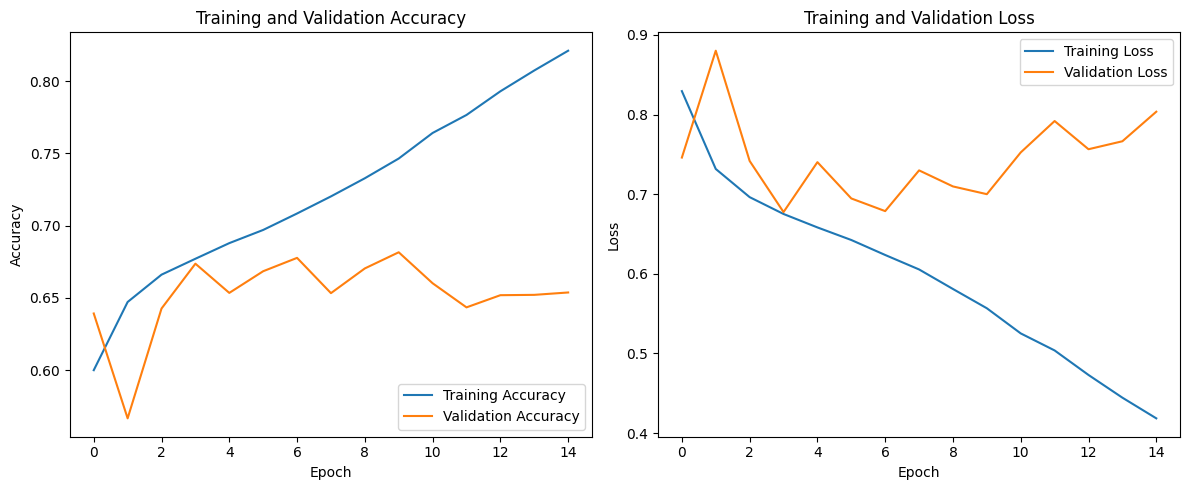


Generating predictions for a sample of validation images...
1/1 [==============================] - 0s 75ms/step


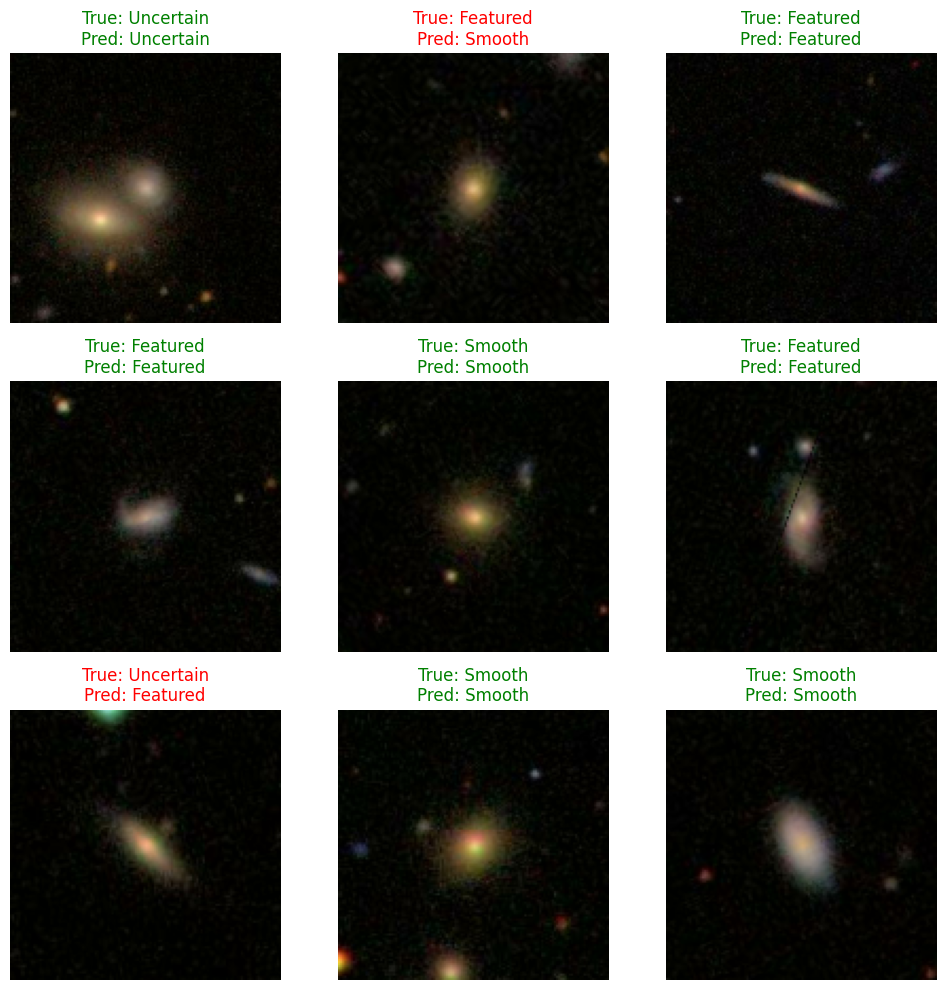

In [8]:
# Evaluate the model on the validation set
print("\nEvaluating model on validation data...")
loss, accuracy = model.evaluate(val_dataset, verbose=0)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

# Plot training history
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.tight_layout()
plt.show()

# Optional: Show some predictions on validation images
print("\nGenerating predictions for a sample of validation images...")
plt.figure(figsize=(10, 10))
# Get a batch from the validation dataset
val_images, val_labels_one_hot = next(iter(val_dataset))

# Make predictions
predictions = model.predict(val_images)

for i in range(min(9, len(val_images))): # Show up to 9 predictions
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(val_images[i].numpy())

    # Get predicted and true labels
    predicted_label_index = np.argmax(predictions[i])
    true_label_index = np.argmax(val_labels_one_hot[i].numpy())

    predicted_class = label_encoder.classes_[predicted_label_index]
    true_class = label_encoder.classes_[true_label_index]

    # Set title color based on correctness
    title_color = "green" if predicted_label_index == true_label_index else "red"

    plt.title(f"True: {true_class}\nPred: {predicted_class}", color=title_color)
    plt.axis("off")

plt.tight_layout()
plt.show()